<h1>GNN with node metrics as features</h1>
One of the advantages of the Graph Neural Networks is the feature engineering, by extracting the necessary features for the neural network.
Here the idea is to feed the feature vector with some metrics extracted from the nodes, and check if the result is better,worse or equal the result without any input feature.

<h2>Install the necessary packages</h2>

In [1]:
# Install torch geometric. This step might take a while
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 43 kB 800 kB/s 
     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 379 kB 29.2 MB/s 
     |████████████████████████████████| 45 kB 1.9 MB/s 


<h2>Helper functions</h2>

In [2]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, figsize=(8,8), labels=False):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=labels,
                          node_color=color, cmap="Set2")
    plt.show()

<h2>Initialize the dataset</h2>

For this experiment, we are going to use Zachary's Karate Club. The dataset contains 34 nodes, linked by members who interacted outside the club.

Processing...
Done!


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


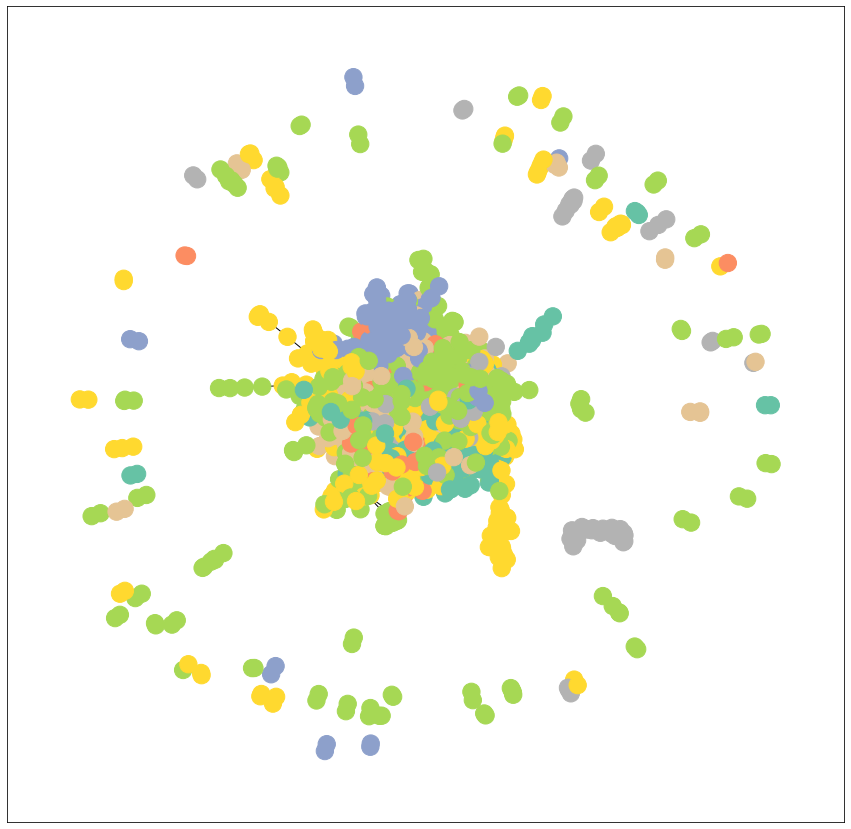

In [3]:
# from torch_geometric.datasets import KarateClub
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

# dataset = KarateClub()
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]  # Get the first graph object.

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y, figsize=(15,15))

<h2>Looking deeper into the data</h2>

In [4]:
print(data)
print(data.x.shape)
print(data.x)
print(data.y)
#print(data.train_mask)
#print(data.y[data.train_mask])
#print(data.edge_index.shape)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 4, 4,  ..., 3, 3, 3])


<h2>The Graph Neural Network Model</h2>

In [64]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)                      

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


<h2>Train function</h2>

In [111]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    # data.x = torch.Size([34, 34])
    # tensor([1., 0., 0., 0., ...])
    # data.edge_index = torch.Size([2, 156])
    # 256 connections between the nodes
    #
    # out => linear classifier
    # h   => final GNN embedding space
    # out, h = model(data.x, data.edge_index)
    out = model(data)

    # Compute the loss solely based on the training nodes.
    # out[data.train_mask] example:
    #   tensor([[0.0069, 0.4383, 0.6527, 0.5311],
    #           [0.0751, 0.4670, 0.6761, 0.5893],
    #           [0.0644, 0.4349, 0.6395, 0.5877],
    #           [0.0887, 0.4226, 0.6209, 0.6145]], grad_fn=<IndexBackward>)
    #
    # data.y[data.train_mask] example:
    #   tensor([1, 3, 0, 2])
    # loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    # Derive gradients
    loss.backward()

    # Update parameters based on gradients
    optimizer.step()

    return out, loss

def run_training(data):
  total = int(data.test_mask.sum())
  max_accuracy = 0

  for epoch in range(401):
      model.train()
      out,loss = train(data)
      
      model.eval()
      correct = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum()
      accuracy = correct / total
      max_accuracy = max(max_accuracy, accuracy)

      if epoch % 10 == 0:
          # visualize(h, color=data.y, epoch=epoch, loss=loss)
          print('Accuracy: {:.2f}%'.format(accuracy*100))
    
  print("Max accuracy: {:.2f}%".format(max_accuracy*100))

<IPython.core.display.Javascript object>

<h2>Explore training</h2>

In [62]:
out,loss = train(data)
# visualize(h, color=data.y)
# print(out.argmax(dim=1))
# print(data.y)
# Remove train mask to test accuracy
# print(out[data.train_mask == False].argmax(dim=1))
# print(data.y[data.train_mask == False])
# print(data.y[data.train_mask == False])
# print((out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum())
# print((out[data.train_mask == False].argmax(dim=1) == data.y[data.train_mask == False]))

correct = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum()
accuracy = correct / int(data.test_mask.sum())
print(data.y.shape[0])
print(accuracy)

2708
tensor(0.1290)


<h2>Training</h2>

In [68]:
run_training(data)

Accuracy: 15.30%
Accuracy: 69.10%
Accuracy: 72.30%
Accuracy: 74.20%
Accuracy: 74.30%
Accuracy: 73.30%
Accuracy: 73.50%
Accuracy: 75.20%
Accuracy: 75.00%
Accuracy: 74.00%
Accuracy: 73.50%
Accuracy: 73.10%
Accuracy: 74.90%
Accuracy: 75.70%
Accuracy: 75.60%
Accuracy: 76.80%
Accuracy: 74.40%
Accuracy: 74.90%
Accuracy: 75.70%
Accuracy: 76.90%
Accuracy: 74.10%
Accuracy: 77.70%
Accuracy: 75.30%
Accuracy: 75.90%
Accuracy: 75.30%
Accuracy: 76.40%
Accuracy: 75.60%
Accuracy: 76.50%
Accuracy: 76.30%
Accuracy: 76.40%
Accuracy: 75.20%
Accuracy: 76.90%
Accuracy: 76.70%
Accuracy: 75.30%
Accuracy: 76.80%
Accuracy: 75.50%
Accuracy: 76.70%
Accuracy: 75.30%
Accuracy: 75.90%
Accuracy: 76.20%
Accuracy: 77.40%
Max accuracy: 79.30%


<h2>Experiment: fill the data feature vector with random numbers</h2>
Expect getting pretty bad results

In [112]:
from torch_geometric.data import Data

data_with_random_features = Data(x=torch.rand(2708, 1433), edge_index=data.edge_index, y=data.y, train_mask=data.train_mask, test_mask=data.test_mask)
run_training(data_with_random_features)

Accuracy: 10.10%
Accuracy: 31.90%
Accuracy: 10.30%
Accuracy: 10.30%
Accuracy: 10.30%
Accuracy: 10.30%
Accuracy: 10.30%
Accuracy: 9.10%
Accuracy: 6.40%
Accuracy: 6.40%
Accuracy: 6.40%
Accuracy: 6.40%
Accuracy: 6.40%
Accuracy: 6.40%
Accuracy: 6.40%
Accuracy: 6.40%
Accuracy: 9.10%
Accuracy: 9.10%
Accuracy: 6.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Accuracy: 14.40%
Max accuracy: 31.90%


<h2>Experiment: fill the data feature vector with real metrics</h2>


In [77]:
# Centralities
betweness_centrality = nx.betweenness_centrality(G)
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

In [98]:
# Clustering
triangles = nx.triangles(G)
clustering = nx.clustering(G)
square_clustering = nx.square_clustering(G)

In [107]:
x = data.x
for i,value in enumerate(x):
  # print(x[i][0])
  x[i][0] = betweness_centrality[i]
  x[i][1] = degree_centrality[i]
  x[i][2] = eigenvector_centrality[i]
  x[i][3] = closeness_centrality[i]
  x[i][4] = triangles[i]
  x[i][5] = clustering[i]
  x[i][7] = square_clustering[i]


In [110]:
data_with_metrics = Data(x=x, edge_index=data.edge_index, y=data.y, train_mask=data.train_mask, test_mask=data.test_mask)
run_training(data_with_metrics)

Accuracy: 19.40%
Accuracy: 69.30%
Accuracy: 71.70%
Accuracy: 74.10%
Accuracy: 75.20%
Accuracy: 72.80%
Accuracy: 74.00%
Accuracy: 75.30%
Accuracy: 75.00%
Accuracy: 73.70%
Accuracy: 73.80%
Accuracy: 73.20%
Accuracy: 75.50%
Accuracy: 75.50%
Accuracy: 75.80%
Accuracy: 76.30%
Accuracy: 74.50%
Accuracy: 75.40%
Accuracy: 75.70%
Accuracy: 76.60%
Accuracy: 74.60%
Accuracy: 77.30%
Accuracy: 76.20%
Accuracy: 77.80%
Accuracy: 75.90%
Accuracy: 75.90%
Accuracy: 74.90%
Accuracy: 77.00%
Accuracy: 76.70%
Accuracy: 76.20%
Accuracy: 76.30%
Accuracy: 77.30%
Accuracy: 76.30%
Accuracy: 74.60%
Accuracy: 76.50%
Accuracy: 74.90%
Accuracy: 77.20%
Accuracy: 75.90%
Accuracy: 76.00%
Accuracy: 75.80%
Accuracy: 78.00%
Max accuracy: 79.10%
